In [142]:
%run ../code/utils.ipynb

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import seaborn as sns
from ipywidgets import interact
plt.set_loglevel("warning")

A note on matchup summary data (who played who, total points for each) vs matchup player data (points by position per week per manager):

Playoff weeks can be found in both datasets but in matchup summary data, some data appear missing because they relate to teams who:
- A.) Were disqualified from championship and consolation brackets (13th and 14th place for example)
- B.) Were eliminated from playoff brackets by losing
- C.) Had bye weeks

And therefore there was no corresponding matchup.

On the other hand, their weekly player roster stats were still tracked, meaning there is more weekly data available in matchup player data than in matchup summary data.

**Example:** A team in 14th place in 2023 would not have any matchups beyond week 14 because they did not qualify for any bracket. However, their player stats for weeks 15, 16, and 17 still appear. 

In [144]:
data_dir1 = f"{project_dir}\\data\\matchup_summary\\"
data_dir2 = f"{project_dir}\\data\\matchup_player_data\\"

In [145]:
df = pd.read_csv(data_dir1 + 'to_date_matchup_summaries_tidy.csv')

In [146]:
df.shape

(1932, 14)

In [147]:
df = df[df['manager_name'] != 'unknown']

In [148]:
df.shape

(1932, 14)

### Create a sparse matrix that tracks wins and losses against all other managers

In [191]:
h2h = pd.DataFrame(index=df.index)
# instantiate an empty list that will be populated with the finished manager-specific column names, for convenience later 
winlosscols = []

# project the existing manager column into the new DF
h2h['manager_name'] = df['manager_name']

# get a list of all the managers and sort them so it matches the order of the groupby method later
names = list(df['manager_name'].unique())
names.sort()

# create the columns
# win columns against managers first
for name in names:
    h2h[f"win against {name}"] = 0
    winlosscols.append(f"win against {name}")

# loss columns 
for name in names:
    h2h[f"loss against {name}"] = 0
    winlosscols.append(f"loss against {name}")

# populate the new columns based on win, loss
for index, row in df.iterrows():
    opponent = row['opponent_name']
    if row["win"] == 1:
        h2h.iloc[index, h2h.columns.get_loc(f"win against {opponent}")] = 1
    else:
        h2h.iloc[index, h2h.columns.get_loc(f"loss against {opponent}")] = 1

In [354]:


wincols = winlosscols[:15]
wincols.append("manager_name")
wins_only = h2h[wincols]
wincols.remove("manager_name")

losscols = winlosscols[15:]
losscols.append("manager_name")
losses_only = h2h[losscols]
losscols.remove("manager_name")

In [205]:
# create the matrix of just wins 
win_heatmap = wins_only.groupby("manager_name")[wincols].sum()

In [209]:
# create the matrix of just losses 
loss_heatmap = losses_only.groupby("manager_name")[losscols].sum()

In [215]:
# create a string based matrix that presents wins / losses as "wins - losses"
records = win_heatmap.copy()
for row in win_heatmap.index:
    for column in win_heatmap.columns:
        loss_col = column.replace("win", "loss")
        records.loc[row, column] = f"{records.loc[row, column]} - {loss_heatmap.loc[row,loss_col]}"

C:\Users\mikem\AppData\Local\Temp\ipykernel_36240\839443460.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0 - 0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  records.loc[row, column] = f"{records.loc[row, column]} - {loss_heatmap.loc[row,loss_col]}"
C:\Users\mikem\AppData\Local\Temp\ipykernel_36240\839443460.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0 - 1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  records.loc[row, column] = f"{records.loc[row, column]} - {loss_heatmap.loc[row,loss_col]}"
C:\Users\mikem\AppData\Local\Temp\ipykernel_36240\839443460.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1 - 1' has dtype incompatible with int64, please explicitly cast to a co

In [222]:
win_heatmap.shape

(15, 15)

In [223]:
records.shape

(15, 15)

### Size adjusted, color coded heatmap with record annotations

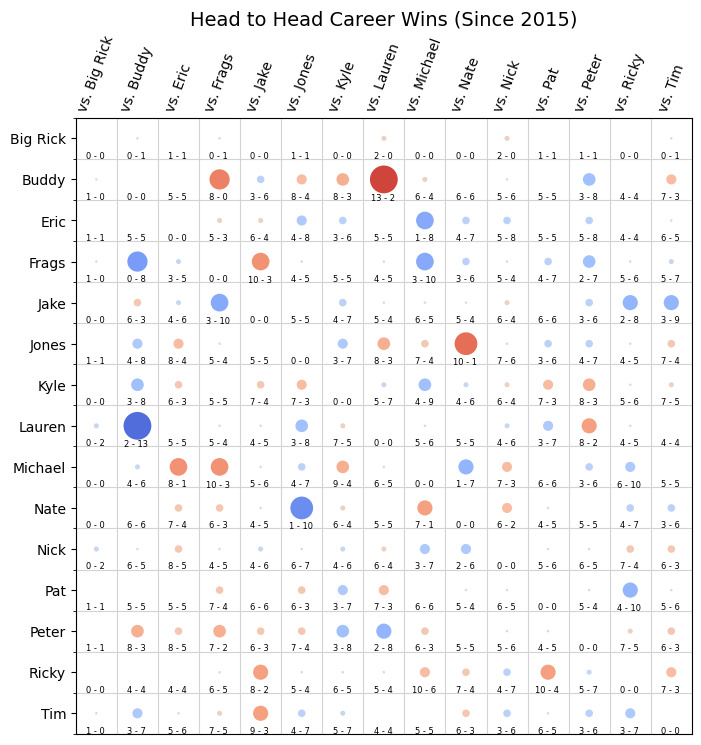

In [353]:
# quick easy rename for better fit on plots
rename = { col_name : col_name.replace('win against', 'vs.') for col_name in wincols}
win_heatmap = win_heatmap.rename(rename, axis=1)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_facecolor('white')
ax.imshow(np.ones_like(win_heatmap), cmap='gray_r', interpolation='nearest')
ax.set_xticks(np.arange(len(win_heatmap.columns)))
ax.set_yticks(np.arange(len(win_heatmap.columns)))
# sns.heatmap(data=win_heatmap, cmap='coolwarm', annot=records, fmt='')
ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, bottom=False, top=True, length=0)

ax.set_yticklabels(win_heatmap.index)
ax.set_xticklabels(win_heatmap.columns, rotation=70)

ax.set_xticks(np.arange(len(win_heatmap.index) + 1) - .5, minor=True)
ax.set_yticks(np.arange(len(win_heatmap.columns) + 1) - .5, minor=True)
ax.grid(which='minor', color="lightgray")

for i in range(len(win_heatmap.columns)):
    for j in range(len(win_heatmap.columns)):
        delta = win_heatmap.iat[j,i] - loss_heatmap.iat[j,i]
        norm = plt.Normalize(loss_heatmap.max().max()*-1,win_heatmap.max().max())
        sm = plt.cm.ScalarMappable(norm=norm, cmap = 'coolwarm')
        color = sm.to_rgba(delta)
        size = abs(delta)/16
        circle = Circle((i, j), radius=abs(delta)/(win_heatmap.max().max()*2.5), facecolor=color)
        ax.add_patch(circle)

        if len(records.iat[j,i]) > 5:
            ax.text(i-0.32, j+0.5, records.iat[j,i], size=6)
        else:
            ax.text(i-0.25, j+0.48, records.iat[j,i], size=6)

plt.title('Head to Head Career Wins (Since 2015)', size = 14);
plt.savefig("size_adjusted_h2h_heatmap")

### Alternative, simpler heatmap

[2024-01-22 18:59:56,027 DEBUG] [matplotlib.colorbar.colorbar._get_ticker_locator_formatter] locator: <matplotlib.ticker.AutoLocator object at 0x0000018F2264B390>
[2024-01-22 18:59:56,027 DEBUG] [matplotlib.colorbar.colorbar._get_ticker_locator_formatter] locator: <matplotlib.ticker.AutoLocator object at 0x0000018F2264B390>


<Axes: ylabel='manager_name'>

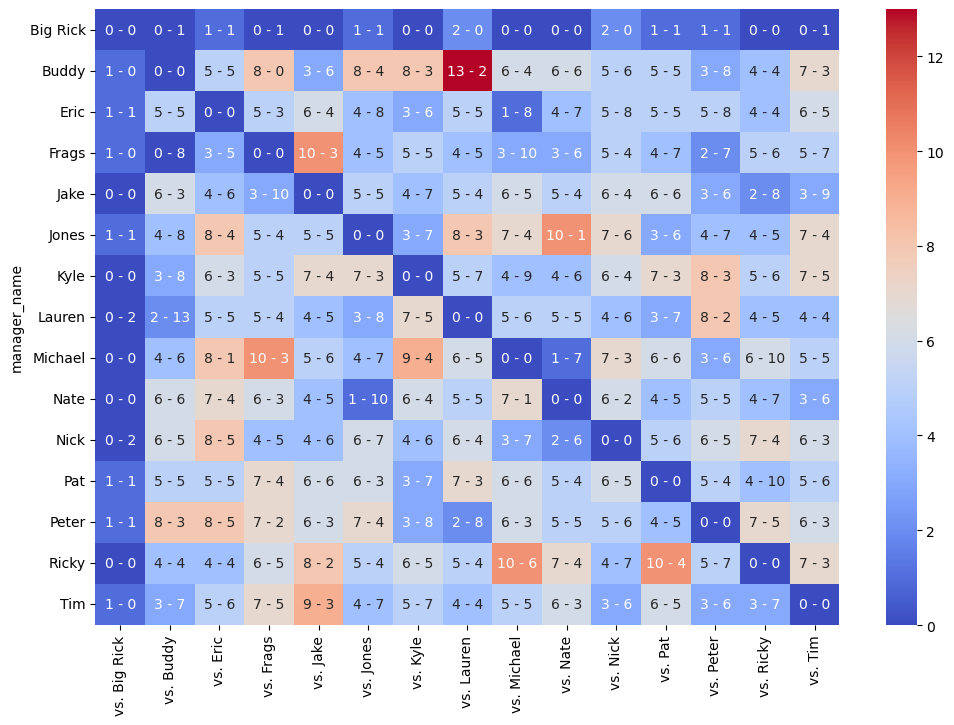

In [345]:
plt.figure(figsize=(12,8))
sns.heatmap(data=win_heatmap, cmap='coolwarm', annot=records, fmt='')

In [141]:
wins_df

,index,week,team_name,in_season_manager_id,manager_name,opponent_team_name,in_season_opponent_manager_id,opponent_name,projected_points_for,points_for,...,win against Lauren,win against Jake,win against Eric,win against Kyle,win against Buddy,win against Pat,win against Nick,win against Frags,win against Jones,win against Nate
0,0,1,The Ice Cold Bruschi,1,Ricky,Jadeveon's Hit Men,3,Tim,105.32,123.80,...,0,0,0,0,0,0,0,0,0,0
1,1,2,The Ice Cold Bruschi,1,Ricky,Thug Bungalow,5,Michael,94.91,106.43,...,0,0,0,0,0,0,0,0,0,0
2,2,3,The Ice Cold Bruschi,1,Ricky,Thunder Crotches,7,Jake,98.54,101.23,...,0,1,0,0,0,0,0,0,0,0
3,3,4,The Ice Cold Bruschi,1,Ricky,The Scientist,9,Kyle,102.49,113.67,...,0,0,0,1,0,0,0,0,0,0
4,4,5,The Ice Cold Bruschi,1,Ricky,Immortal Duffmen,11,Pat,76.25,122.47,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,1917,2,who invited canada,14,Peter,Jadeveon's Hit Men,3,Tim,109.15,155.04,...,0,0,0,0,0,0,0,0,0,0
962,1925,10,who invited canada,14,Peter,John Brown's Army,4,Eric,103.95,151.18,...,0,0,1,0,0,0,0,0,0,0
963,1926,11,who invited canada,14,Peter,The fishingtons,8,Buddy,110.37,129.84,...,0,0,0,0,1,0,0,0,0,0
964,1927,12,who invited canada,14,Peter,Wereback,13,Nate,117.32,101.60,...,0,0,0,0,0,0,0,0,0,1


In [130]:
df1 = pd.read_csv(data_dir1 + 'to_date_matchup_summaries_tidy.csv')

In [131]:
df2 = pd.read_csv(data_dir2 + 'matchup_player_data_through_2023.csv')
df2['season_week'] = df2['manager'] + '|' + df2['season'].astype(str) + '|' + df2['week'].astype(str)

In [132]:
df1.set_index('season_week', inplace= True)

In [133]:
df2.set_index('season_week', inplace= True)

In [134]:
df = df1.join(df2, how = 'left', rsuffix='_roster_data')

In [135]:
df_pre2021 = df[df['season'] < 2021].copy()
df_pre2021['playoff_week'] = np.where(df_pre2021['week'] >= 14, 1, 0)


In [136]:
df_2021on = df[df['season'] >= 2021].copy()
df_2021on['playoff_week'] = np.where(df_2021on['week'] >= 15, 1, 0)

In [137]:
df = pd.concat([df_pre2021, df_2021on])

In [138]:
@interact

def points_for_explorer( season = df['season'].unique()):

    pf_win_df = df[df['season'] == season][['team_name', 'points_for', 'win']].copy()
    median_winning = np.median(pf_win_df[pf_win_df['win'] == 1]['points_for'])
    median_losing = np.median(pf_win_df[pf_win_df['win'] == 0]['points_for'])
    fig = plt.figure(figsize=(8,8))
    plt.xlim(0, df['points_for'].max() )
    sns.kdeplot(pf_win_df[pf_win_df['win'] == 0], x = 'points_for', fill=True, label = 'Lost', color='goldenrod')
    sns.kdeplot(pf_win_df[pf_win_df['win'] == 1], x = 'points_for', fill=True, label = 'Won', color='blue')
    x, y = plt.gca().get_ylim()
    plt.vlines(median_losing, ymin=0, ymax= y, colors='darkorange', label='Median Losing Points')
    plt.vlines(median_winning , ymin=0, ymax= y, colors='navy', label='Median Winning Points')
    plt.legend()
    plt.show;
    bad_breaks = df[(df['points_for'] > median_winning) & (df['win'] == 0) & (df['season'] == season)][['manager','week','team_name', 'points_for', 'win', 'opponent_team_name']].copy()
    bad_breaks['note'] = 'Bad break!'
    lucky_breaks = df[(df['points_for'] < median_losing) & (df['win'] == 1) & (df['season'] == season)][['manager','week','team_name', 'points_for', 'win', 'opponent_team_name']].copy()
    lucky_breaks['note'] = 'Got lucky!'
    results_df = pd.concat([bad_breaks, lucky_breaks])
    return results_df

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …

In [139]:
managers = np.asarray('All')
managers = np.append(managers, df['manager'].unique())
sort_by_values = ['Mean Score', 'Score Standard Deviation', 'Lowest Score', 'Highest Score']
@interact 
def regular_season_points_for_fast_facts( season = df['season'].unique(), manager = managers, include_playoff = ['No','Yes'], sort = sort_by_values):
    
    # establish a dynamic mask that changes based on whether playoff weeks are included or not
    playoff_mask = True if include_playoff == "Yes" else df['playoff_week'] == 0 
    
    # Get average values of the aggregate functions by season so they can be appended to the filtered result
    season_df = df[(df['season'] == season) & (playoff_mask)].groupby('manager')['points_for'].describe()
    season_averages = {k:season_df[k].mean() for k in season_df.columns}
    season_average_df = pd.DataFrame(season_averages, index = ['League Average'])
    
    # conditional for specific manager filter
    if manager != 'All':
        filtered_df = df[(df['season'] == season) & (df['manager'] == manager) & (playoff_mask)]['points_for'].describe()
        # A single manager results in a series, so it is converted to a dataframe and transposed to fit the format
        filtered_df = pd.DataFrame(filtered_df)
        filtered_df = filtered_df.T
        
    # conditional for no filter on managers (All)
    else: 
        filtered_df = season_df
         
    
    # make column names of both the filtered_df and season_averages_df friendlier
    column_names = ['Weeks', 'Mean Score', 'Score Standard Deviation', 'Lowest Score', '25th Percentile', '50th Percentile', '75th Percentile', 'Highest Score']
    season_average_df.rename({old:new for (old, new) in zip(season_average_df.columns, column_names)}, axis = 1, inplace = True)
    filtered_df.rename({old:new for (old, new) in zip(filtered_df.columns, column_names)}, axis = 1, inplace = True)
    
    
    # sorting filter, with conditional for lowest score since it makes sense to have it at the top
    if sort != 'Lowest Score':
        filtered_df = filtered_df.sort_values(sort, ascending = False)
    else:
        filtered_df = filtered_df.sort_values(sort, ascending = True)
    
    filtered_df = pd.concat([filtered_df, season_average_df])
    return filtered_df
    

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …

In [140]:
@interact
def highest_score_explorer( season = df['season'].unique()):
    '''
    Returns a dataframe of each manager's highest score for the season and shows that week's results
    '''
    max_df = pd.DataFrame(df[(df['season'] == season)].groupby('manager_name')['points_for'].max())
    losses_to_max = pd.DataFrame()
    for manager in max_df.index:
        manager_max = max_df.loc[manager, 'points_for'].item()
        season_df = df[df['season'] == season]
        relevant_row = season_df.loc[ df['points_for'] == manager_max, ['season', 'week', 'manager_name', 'points_for',  'win','opponent_name', 'points_against']]
        relevant_row['win'] = np.where(relevant_row['win'] == 1, 'Won', 'Lost')
        opponent = relevant_row['opponent_name']
        opponent_pts = relevant_row['points_against']
        relevant_row["was opponent's highest score"] = np.where(max_df.loc[opponent, 'points_for'].item() == opponent_pts, 'Yes', 'No')
        losses_to_max = pd.concat([losses_to_max, relevant_row], ignore_index= True)
    losses_to_max.rename({'manager_name' : 'manager',
                         'points_for' : 'scored',
                         'win' : 'result',
                         'opponent_name' : 'against',
                         'points_against': 'opponent scored'}, axis = 1, inplace = True)
    losses_to_max = losses_to_max.sort_values('scored', ascending=False)
    return losses_to_max

interactive(children=(Dropdown(description='season', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, …